<a href="https://colab.research.google.com/github/bashhwu/Automatic-Essay-Scoring/blob/main/essayset1%3DGlove%2Bregression%2BDense%2Bval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
clear all

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
embedding_size=200

In [6]:
ls

drive/  sample_data/


In [7]:
mypath='/content/drive/MyDrive/AAAAA'

In [8]:
import io
import pandas as pd

df = pd.read_csv(mypath+'/asap_training_data.tsv',sep='\t', encoding='ISO-8859-1')
df_test = pd.read_csv(mypath+'/asap_valid_set.tsv',sep='\t', encoding='ISO-8859-1')
test_score = pd.read_csv(mypath+'/asap_valid_scores.csv')


df.shape

(12976, 28)

In [9]:
X_test=df_test[df_test['essay_set']==1]['essay']

In [10]:
X_test.shape

(589,)

In [11]:
y_test=test_score[test_score['essay_set']==1]['predicted_score']

In [12]:
y_test.shape

(589,)

In [13]:
X = df.dropna(axis=1) 
X =X[X['essay_set']==1]
X = X.drop(columns=['essay_id','essay_set','rater1_domain1', 'rater2_domain1'])

y = X['domain1_score'] # Only domain1_score is considered
X=X['essay']

In [14]:
X.shape, y.shape

((1783,), (1783,))

In [15]:
X.head()

0    Dear local newspaper, I think effects computer...
1    Dear @CAPS1 @CAPS2, I believe that using compu...
2    Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...
3    Dear Local Newspaper, @CAPS1 I have found that...
4    Dear @LOCATION1, I know having computers has a...
Name: essay, dtype: object

In [16]:
X_total=pd.concat([X, X_test], sort=False)

In [17]:
X_total.shape

(2372,)

### Load the Glove embedding vectors

In [18]:
import numpy as np

# load the whole embedding into memory
embeddings_index = dict()
f = open(mypath+'/glove.6B.'+str(embedding_size)+'d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [19]:
mypath+'/glove.6B.'+str(embedding_size)+'d.txt'

'/content/drive/MyDrive/AAAAA/glove.6B.200d.txt'

In [20]:
# embeddings_index is a dictionary with keys representing words
# and values representing embedding vectors
embeddings_index['the'].shape, len(embeddings_index)

((200,), 400000)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer  # instead of one-hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
nltk.download('stopwords')
  
from nltk.corpus import stopwords

def to_sequence(X, remove_stopwords=False): 
    # X is a dataframe
    stops = set(stopwords.words("english"))

    t =Tokenizer(num_words=None,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
    docs=[]
    for i in range(X.shape[0]):
      ess=X.iloc[i]

      if remove_stopwords:
         ess=[word for word in ess.split() if word not in stops ]
      else:
        ess=ess

      docs.append(ess)  # list of essays (end of for loop)
          
    t.fit_on_texts(docs)  # The entire data
    vocab_size = len(t.word_index) + 1  # calculated based on the whole dataset

    # integer encode the documents
    encoded_docs = t.texts_to_sequences(docs)  # word to index
    l=[]

    max_length=max([len(d) for d in encoded_docs ])

    # pad documents to a max length of max_length words
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    return t, padded_docs, max_length, vocab_size

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
t, padded_docs, max_length, vocab_size, =to_sequence(X_total, remove_stopwords=False)

In [23]:
padded_docs.shape, vocab_size, y.shape, max_length

((2372, 795), 19048, (1783,), 795)

In [24]:
padded_docs_train=padded_docs[:X.shape[0]]
padded_docs_test=padded_docs[X.shape[0]:]

In [25]:
padded_docs_train.shape, X.shape, padded_docs_test.shape, X_test.shape, y.shape, y_test.shape


((1783, 795), (1783,), (589, 795), (589,), (1783,), (589,))

#### Seed the embedding matrix with vectors from a pretrained model

In [26]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, embedding_size))
  
for word, i in t.word_index.items():  # i is index 
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [27]:
embedding_matrix  # Embedding matrix before training

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.071549  ,  0.093459  ,  0.023738  , ...,  0.33616999,
         0.030591  ,  0.25577   ],
       [ 0.57345998,  0.54170001, -0.23477   , ...,  0.54417998,
        -0.23069   ,  0.34946999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
y.unique()

array([ 8,  9,  7, 10,  6, 12,  4,  3, 11,  2,  5])

In [29]:
output_neurons=len(y.unique())
output_neurons

11

In [30]:
# define model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding
from tensorflow import keras
from keras.callbacks import *

def get_model():
    model = Sequential()
    e = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_length, trainable=True)
    model.add(e)
    model.add(Flatten())
    model.add(Dropout(0.2))

    
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(100, activation='relu')) # 100 50 25
    model.add(Dropout(0.2))

    #model.add(Dense(10, activation='relu'))


    model.add(Dense(1))
    
    # compile the model
    opt = keras.optimizers.Ftrl()
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])



    #Adding callbacks
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)  
    #mc=ModelCheckpoint(mypath+'/regression+dense+best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  

    # summarize the model
    print(model.summary())
    return model


In [31]:
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True)

In [32]:
from keras.models import load_model

kappa=[]
count=1
for train_index, test_index in cv.split(padded_docs_train):
    print("\n--------Fold {}--------\n".format(count))
    X_val, X_train, y_val, y_train = padded_docs_train[test_index], padded_docs_train[train_index], y.iloc[test_index], y.iloc[train_index]
    model=get_model()
    print(X_train.shape, y_train.shape,X_val.shape, y_val.shape)
    #model.fit(X_train, y_train, batch_size=64, epochs=150)
    
    #Adding callbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)  
    mc=ModelCheckpoint(mypath+'/regression+dense+best_model'+str(count)+'.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  

    history = model.fit(X_train, y_train, batch_size=64, epochs=150,validation_data=(X_val,y_val.values),verbose=1,callbacks=[es,mc])
    #loading best model
    model= load_model(mypath+'/regression+dense+best_model'+str(count)+'.h5')
    
    
    y_pred = model.predict(X_val)
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    result = cohen_kappa_score(y_val.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    kappa.append(result)
    count+=1



--------Fold 1--------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 795, 200)          3809600   
_________________________________________________________________
flatten (Flatten)            (None, 159000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 159000)            0         
_________________________________________________________________
dense (Dense)                (None, 200)               31800200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (N

In [33]:
kappa

[0.8106394835833373, 0.7886449884664037, 0.8157546672909229]

In [34]:
np.mean(kappa).round(3)

0.805

In [35]:
#loading best model
from keras.models import load_model
model1= load_model('/content/drive/MyDrive/AAAAA/regression+dense+best_model1.h5')
model2= load_model('/content/drive/MyDrive/AAAAA/regression+dense+best_model2.h5')
model3= load_model('/content/drive/MyDrive/AAAAA/regression+dense+best_model3.h5')

In [42]:
R=pd.DataFrame(np.zeros((1)), index=['QWK'], columns=['Model3'])

In [43]:
R

,Model3
QWK,0.0


In [44]:
y_pred1 = model1.predict(padded_docs_test).round()
y_pred2 = model2.predict(padded_docs_test).round()
y_pred3 = model3.predict(padded_docs_test).round()

R['Model3']=cohen_kappa_score(y_test.values,y_pred3,weights='quadratic').round(3)

In [45]:
R

,Model3
QWK,0.864


In [46]:
y_pred3=y_pred3.reshape((1,589))[0]

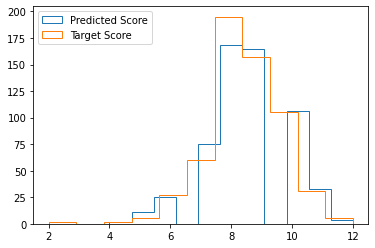

In [48]:
import matplotlib.pyplot as plt
plt.hist(y_pred3,bins=11, histtype='step')
plt.hist(y_test,bins=11, histtype='step')
plt.legend(['Predicted Score', 'Target Score'], loc='upper left')

# New Scenario: Averaging word embeddings

In [ ]:
M=model.layers[0].get_weights()[0]

In [ ]:
M.shape

In [ ]:
padded_docs

In [ ]:
new_data=np.zeros((padded_docs.shape[0], M.shape[1]))
for i in range(padded_docs.shape[0]):
   b=padded_docs[i]
   b=b[b!=0]
   new_data[i]=M[b].mean(axis=0)


In [ ]:
new_data.shape

In [ ]:
# define model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding
from tensorflow import keras

def get_new_model():
    model = Sequential()
    model.add(Dense(400, input_shape=(embedding_size,),activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(400, activation='relu')) # 100 50 25
    model.add(Dropout(0.2))

    model.add(Dense(10, activation='relu'))


    model.add(Dense(1))
    
    # compile the model
    opt = keras.optimizers.Adam()
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    # summarize the model
    print(model.summary())
    return model


In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True)

In [ ]:
kappa=[]
count=1
for train_index, test_index in cv.split(new_data):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = new_data[test_index], new_data[train_index], y.iloc[test_index], y.iloc[train_index]
    model=get_new_model()
    print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)
    model.fit(X_train, y_train, batch_size=64, epochs=200)
    y_pred = model.predict(X_test)
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    kappa.append(result)
    count+=1


In [ ]:
kappa

In [ ]:
np.mean(kappa)

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/#:~:text=2.-,Keras%20Embedding%20Layer,API%20also%20provided%20with%20Keras.